# Creating your own Mean

Previously, we have used defined means (constant mean, zero mean, linear mean, etc). This is in line with the idea that the mean adjusts itself to the data and provides the prediction and inference. However, there are cases where we already know how the mean looks (e.g. straight line, polynomial, dynamic model).

By using the mean, we make the task of learning the mean easier. Further, we can use the mean and error bars to predict the value of the mean in the future based on previously observed data.

Take the following example:

$ f(x) = ax^3 + bx^2 + cx + d \quad \forall x \in [0,1]$

$ y = f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0,\sigma^2)$

For this case, let $a = 3$, $b = -2$, $c = 4$, $d = 5$, $\sigma = 0.1$.

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(1234)
σ = 0.1
a, b, c, d = 3, -2, 4, 5
x = np.linspace(0,1,21)
X = np.stack([x**3, x**2, x, np.ones(x.size)])
A = np.array([a,b,c,d])
f = np.dot(A, X)
y = f + np.random.randn(f.size) * σ

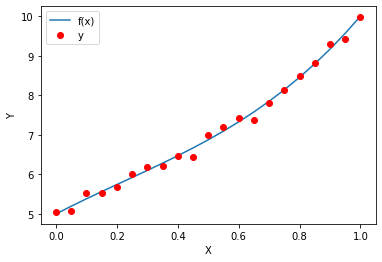

In [3]:
plt.plot(x,f)
plt.plot(x,y, 'ro')
plt.legend(['f(x)', 'y'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

To show why defining a mean would be useful, given we know a structure to it, let us form a GPR with data only from 0 to 0.5 and then attempt to predict 0.5 to 1.

In [4]:
torch.manual_seed(1234)
train_x = torch.linspace(0,0.75,16)
train_y = torch.matmul(torch.Tensor(A), torch.Tensor(torch.stack([train_x**3, train_x**2, train_x, torch.ones(train_x.size())]))) + torch.randn(train_x.shape) * σ

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size = 1, bias = False)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.weights', tensor([[-0.2669]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter = 500

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [8]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [9]:
test_x = torch.linspace(0, 1 , 101)
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

# f_mean = f_pred.mean
# f_var = f_pred.variance
# f_covar = f_pred.covariance_matrix
# f_samples = f_pred.sample(sample_shape=torch.Size([100]))

y_mean = y_pred.mean
y_var = y_pred.variance
lb, ub = y_pred.confidence_region()

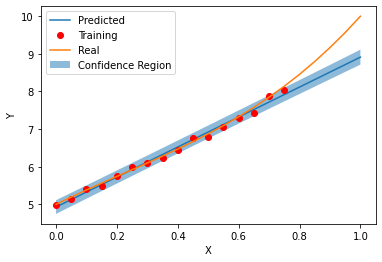

In [10]:
plt.plot(test_x.detach().numpy(), y_mean.detach().numpy())
plt.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'ro')
plt.plot(x,f)
plt.fill_between(test_x, lb.detach().numpy(), ub.detach().numpy(), alpha = 0.5)
plt.legend(['Predicted', 'Training', 'Real', 'Confidence Region'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

As we can see, without a known mean, the model prediction (and thus, likelihood) start to move towards a constant mean as it was mentioned in the model setup. If we use this idea to our advantage, and give a well-structured equation for the mean, we can get a better predictor.

Firstly, we have to create a new mean class. Let us class it Poly3Mean

In [11]:
class Poly3Mean(gpytorch.means.Mean):
    def __init__(self, input_size, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter(name="a", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        self.register_parameter(name="b", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        self.register_parameter(name="c", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        self.register_parameter(name="d", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))

    def forward(self, x):
        res = self.a * x**3 + self.b * x**2 + self.c * x + self.d
        return res.squeeze()

In [12]:
class Poly3GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Poly3GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = Poly3Mean(input_size = 1)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Poly3GPModel(train_x, train_y, likelihood)

In [13]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.a', tensor([[2.1785]])),
             ('mean_module.b', tensor([[0.1021]])),
             ('mean_module.c', tensor([[-0.2590]])),
             ('mean_module.d', tensor([[-0.1549]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',


In [14]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter = 500

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [15]:
print(loss)
model.eval()
likelihood.eval()

tensor(-1.4387, grad_fn=<NegBackward>)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [16]:
test_x = torch.linspace(0, 1 , 101)
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

# f_mean = f_pred.mean
# f_var = f_pred.variance
# f_covar = f_pred.covariance_matrix
# f_samples = f_pred.sample(sample_shape=torch.Size([100]))

y_mean = y_pred.mean
y_var = y_pred.variance
lb, ub = y_pred.confidence_region()

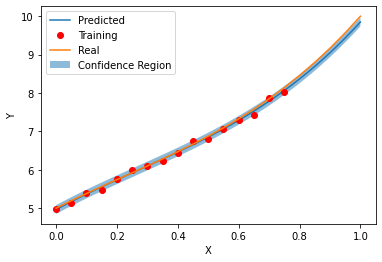

In [17]:
plt.plot(test_x.detach().numpy(), y_mean.detach().numpy())
plt.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'ro')
plt.plot(x,f)
plt.fill_between(test_x, lb.detach().numpy(), ub.detach().numpy(), alpha = 0.5)
plt.legend(['Predicted', 'Training', 'Real', 'Confidence Region'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()